# Get Sample Colors
> Get sample colors by using [K-Means Clustering](https://en.wikipedia.org/wiki/K-means_clustering)

[Back to <b>contents</b>](../README.md)

First, represent the main colors of shoe in shoes.csv in 3D. <br>
Numpy, Matplotlib and csv libraries are needed

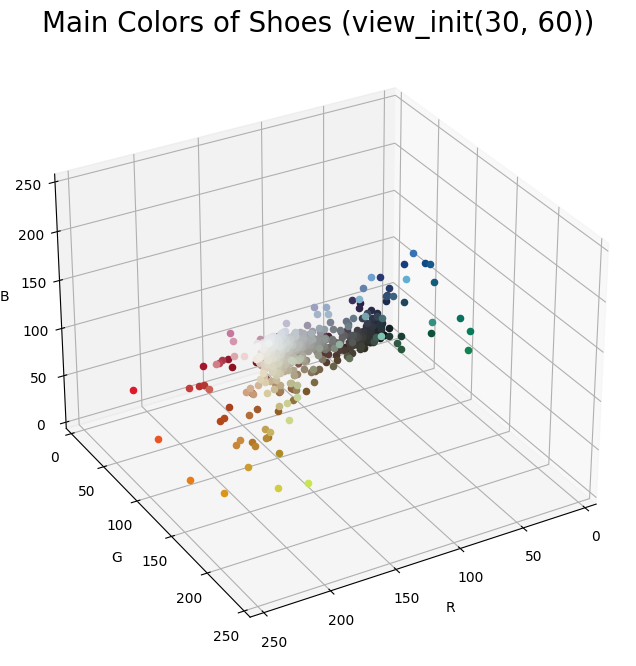

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import csv
%matplotlib inline
def load_shoe_data(filename):
  class ShoeData:
    data = []
    target = []
    feature_names = ['Name','Brand','Colors','Link','wish','review']
  shoes = ShoeData()
  with open(filename,'r', encoding ='utf-8') as f:
    for items in csv.reader(f):
      if items[0].startswith('#'): continue
      shoes.target.append(eval(items[2]))
      shoes.data.append(items)
    shoes.data = np.array(shoes.data)
    return shoes

shoes = load_shoe_data('../data/shoes.csv')
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d', xlabel ="R", ylabel ="G", zlabel ="B")
ax.set_title("Main Colors of Shoes (view_init(30, 60))", size = 20)

for colors in shoes.target:
  RGBP = colors[0]
  RGB = np.array(RGBP[:-1])
  ax.scatter(RGB[0], RGB[1], RGB[2], color = RGB/255.0)
  
ax.view_init(30, 60)

Each view_init show plot by different angles.
<br>
<img src = "../img/MCS.png" width = 800vw>

### Data analysis
1. As expected, the main colors of shoe are mostly achromatic.
2. <span style ="background-color : Black; color : white;">Black</span> and <span style ="background-color : White; color : Black;">white</span> are usually abundant, and the rest of the colors are evenly distributed.
3. But we can't get suitable colors with this information.


## Goal
> I want to compress <b>color information</b> into <b>less number of colors</b>.
1. A small number of colors should <mark>effeciently</mark> represent the color of the shoes.
2. Similar colors should be removed. To do this, divide the colors into groups.

    **Use [KMeans](https://en.wikipedia.org/wiki/K-means_clustering) clustering**


In [38]:
from sklearn.cluster import KMeans #for K-Means
import pandas as pd

* Import the necessary modules. <br>
* Then, we convert the data we get into a <b>data frame</b> and convert it into a <b>float type</b>.


In [39]:
data = []
for colors in shoes.target:
  RGBP = colors[0]
  RGB = np.array(RGBP[:-1])
  data.append(RGB)
data
df = pd.DataFrame(columns=['R','G','B'], data=data)
df.head(10)

,R,G,B
0,218,222,224
1,203,204,206
2,52,51,50
3,199,204,206
4,223,226,227
5,172,174,182
6,162,126,87
7,52,51,50
8,131,89,52
9,209,212,216


In [40]:
df[['R','G','B']].std()

R    77.323959
G    76.521322
B    75.205438
dtype: float64

 > First, let's get the result by setting the number of K-means clusters to 3.

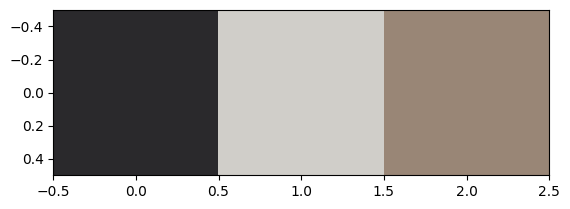

In [41]:
points = df.values
k = 3
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.round().astype(int)
plt.imshow([centers])


Modify the dataframe to map the centers to each color.

In [42]:
df['cluster'] = kmeans.labels_
colors = []
for row in df['cluster']:
  colors.append(centers[row].round())
df['color'] = colors
df.head(5)

,R,G,B,cluster,color
0,218,222,224,1,"[208, 206, 201]"
1,203,204,206,1,"[208, 206, 201]"
2,52,51,50,0,"[42, 41, 44]"
3,199,204,206,1,"[208, 206, 201]"
4,223,226,227,1,"[208, 206, 201]"


Based on this, draw a 3d plot.

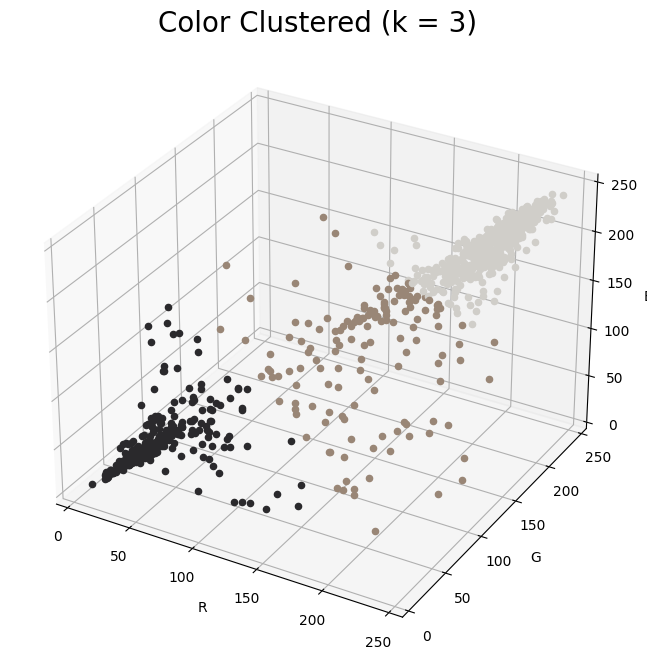

In [43]:
fig = plt.figure(figsize = (8, 8))
ax2 = fig.add_subplot(111, projection='3d', xlabel ="R", ylabel ="G", zlabel ="B")
ax2.set_title(f"Color Clustered (k = {k})", size = 20)
for index, row in df.iterrows():
  ax2.scatter(row['R'], row['G'], row['B'], color = row['color']/255.0)
plt.show()

As shown in the image above, it seems to be well mapped with 3 colors.
> Now we will cluster with 25 colors. <br>  - ([colorsort.py](colorsort.py) has sort function for colors)

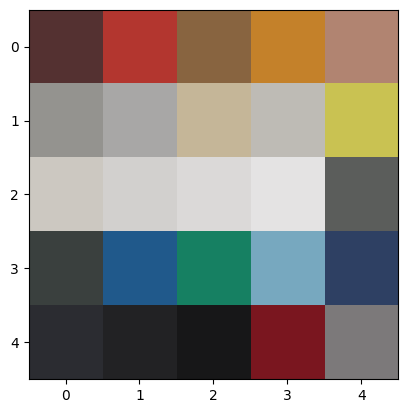

In [44]:
import copy
import mycolor
k = 25
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.round().astype(int)
arr_2d = copy.deepcopy(centers.tolist())
mycolor.sort(arr_2d)
arr_2d = np.reshape(arr_2d, (5,5,3))
plt.imshow(arr_2d)

Based on this, draw a 3d plot.

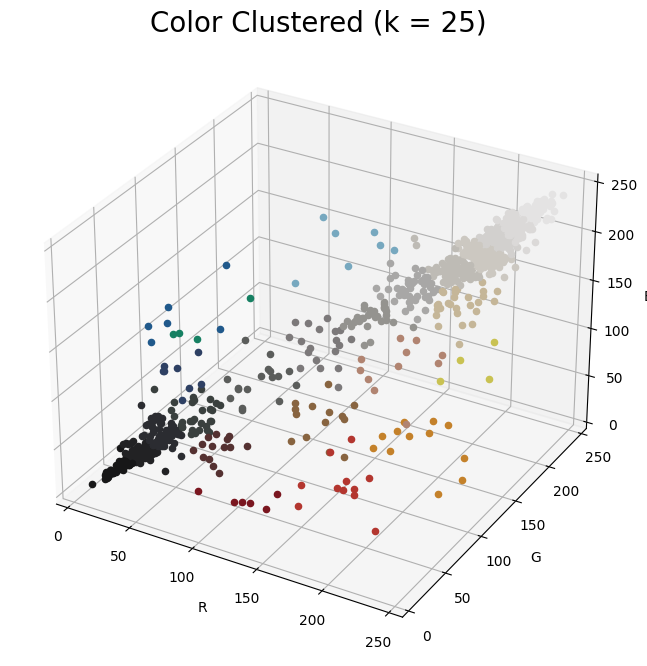

In [45]:
df['cluster'] = kmeans.labels_
colors = []
for row in df['cluster']:
  colors.append(centers[row])
df['color'] = colors
fig = plt.figure(figsize = (8, 8))
ax2 = fig.add_subplot(111, projection='3d',xlabel ="R", ylabel ="G", zlabel ="B")
ax2.set_title(f"Color Clustered (k = {k})", size = 20)
for index, row in df.iterrows():
  ax2.scatter(row['R'], row['G'], row['B'], color = row['color']/255.0)
plt.show()

Although we got 25 colors from 1000 colors, <B>there are too many similar colors</B>.
> * To solve this problem, I found that multiple clustering will solve this.
> * With <b>k</b> and difference <b>d</b> as the number of initial clusters, a color palette is extracted with appropriate <b>k</b> and <b>d</b>. Here we use (300, 3)

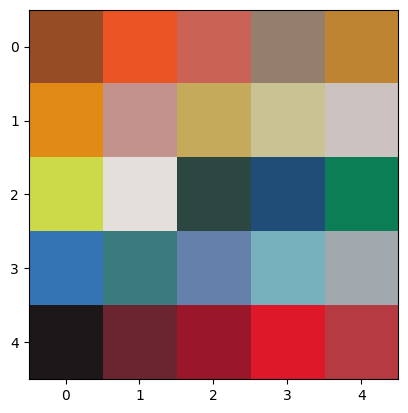

In [46]:
k, d = 500, 3 #initial cluster numbers, difference
kmeans = KMeans(n_clusters = k).fit(points)
centers = kmeans.cluster_centers_.round().astype(int)
df['cluster'] = kmeans.labels_
while k > 25 :  #target numbers : k = 5
  if k - d < 25 : k = 25
  else : k -= d
  kmeans = KMeans(n_clusters = k).fit(centers)
  centers = kmeans.cluster_centers_.round().astype(int)
  labels = []
  for row in df['cluster']:
    labels.append(kmeans.labels_[row])
  df['cluster'] = labels

arr_2d = copy.deepcopy(centers.tolist())
mycolor.sort(arr_2d)
arr_2d = np.reshape(arr_2d, (5,5,3))
plt.imshow(arr_2d)

You can see that the color palette came out more evenly than before. <br>
Based on this, draw a 3d plot.


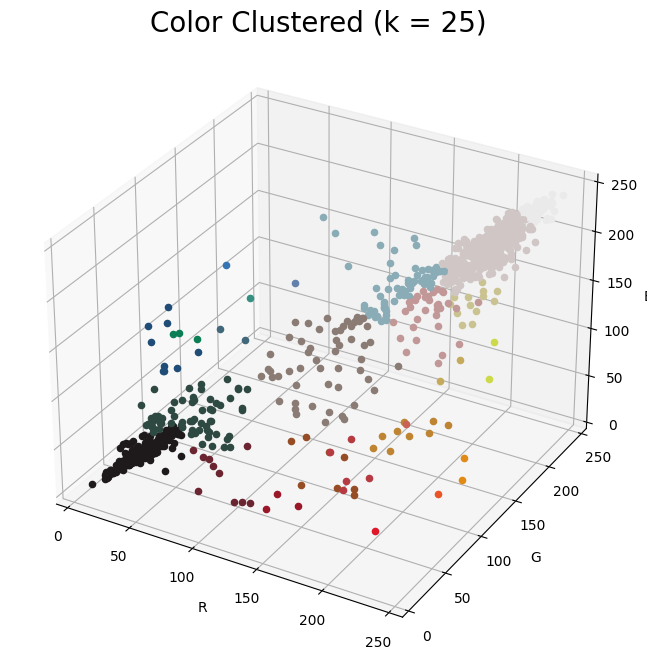

In [64]:
fig = plt.figure(figsize = (8, 8))
ax2 = fig.add_subplot(111, projection='3d',xlabel ="R", ylabel ="G", zlabel ="B")
ax2.set_title(f"Color Clustered (k = {k})", size = 20)
for index, row in df.iterrows():
  ax2.scatter(row['R'], row['G'], row['B'], color = row['color']/255.0)
plt.show()

* We need to find the closest color to the colors we found.
* Mycolor has a closest_color function based on css color, but it doesn't give good results.
* So, I used ArtyClick ["Color Name Finder"](https://colors.artyclick.com/color-name-finder/) to get more universal colors.
* Before that, save the rgb values ​​we collected as a csv file.


In [75]:
csvFile = open("../data/original_RGB.csv", 'w', encoding='utf-8',newline='')
writer = csv.writer(csvFile)
writer.writerow(('#R','G','B'))
for rgb in centers:
  writer.writerow(rgb)
csvFile.close()

Find adjacent RGB and its names of 25 colors and save them as a csv file.
<img src ="../img/original_rgbcsv.png" width ="400">